In [1]:
%load_ext autoreload
%autoreload 2

### Comparison with random path

In [15]:
from src.models.markov_chains import *
from src.utils.HTMLParser import HTMLParser
from src.utils.helpers import *
from src.data.data_loader import *
import pandas as pd
import matplotlib.colors as mcolors
import plotly.express as px
import numpy as np
import config

parser = HTMLParser()
parser.load_pickle()

In [3]:
df_article_names, df_html_stats, df_categories, df_links, df_shortest_path, df_unfinished, df_finished, df_sm, df_scat, df_article = read_all()

Unfinished Paths
---------------- 
Number of rows before filtering: 24875
Invalid target articles found: {'Black ops 2', 'The Rock', 'Christmas', 'The', 'Test', 'Great', 'Fats', 'Rat', ' Zebra', 'Podcast', 'Mustard', 'Kashmir', 'Usa', 'Bogota', 'Long peper', 'Rss', 'English', 'Georgia', 'Macedonia', 'Charlottes web', 'Sportacus', 'Pikachu', 'Netbook', 'Adolph Hitler', 'Western Australia'}
Invalid articles found in path: {'Private Peaceful', 'Local community', 'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License', 'Pikachu'}
Number of 'timeout' games with a duration of less than 30 minutes: 7
Number of rows after filtering: 24709 

Finished Paths
-------------- 
Number of rows before filtering: 51318
Invalid articles found in path: {'Osteomalacia', 'Wikipedia Text of the GNU Free Documentation License', 'Local community', 'Pikachu'}
Number of rows after filtering: 51196


In [183]:
df_paths = pd.concat([df_finished[['path', 'path_length']], df_unfinished[['path', 'path_length']]])

In [184]:
backclick_articles = pd.concat([pd.Series(['<']), df_article_names]).reset_index(drop=True)
backclick_categories = df_categories[['article', 'level_1']]
backclick_categories = pd.concat([pd.DataFrame([['<', '<']], columns=['article', 'level_1']), backclick_categories], ignore_index=True)

In [185]:
backclick_markov = get_transition_probabilities(df_article_names, parser, backclicks=True)
backclick_users= get_nth_transition_matrix(df_paths, backclick_articles, transition=1)

,<,Áedán mac Gabráin,Åland,Édouard Manet,Éire,Óengus I of the Picts,€2 commemorative coins,10th century,11th century,12th century,...,Ziad Jarrah,Zimbabwe,Zinc,Zinc chloride,Zion National Park,Zionism,Zirconium,Zoroaster,Zuid-Gelders,Zulu
<,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Áedán mac Gabráin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Åland,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Édouard Manet,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Éire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Zionism,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zirconium,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zoroaster,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Zuid-Gelders,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False)
user_transitions = get_nth_transition_matrix(df_finished, df_article_names, 1)

print(f'Non-zero values of random transitions: {np.count_nonzero(markov_transitions)}')
print(f'Non-zero values of user transitions: {np.count_nonzero(user_transitions.to_numpy())}')

Non-zero values of random transitions: 119855
Non-zero values of user transitions: 25151


<div class="alert alert-block alert-info">

The transition matrix's $P$ left eigenvector with eigenvalue 1 (i.e. $x$ such that $xP=x$) is called the steady-state of the system. Let's call the normalised vector $x = (x_1, x_2, \dots, x_N)$, where the sum of all $x_i$ is 1. After $\infty$ iterations, starting from whatever article, the probability distribution of the end article is given by $x$. 

**Example**: For 3 articles, let's say that we have $x=(0.2, 0.3, 0.5)$. Then, when starting from any of the articles and taking infinitely many steps, there is probability 0.2 to be in article 1, probability 0.3 to be in article 2 and probability 0.5 to be in article 3.

</div>

In [5]:
ss = compute_steady_state(markov_transitions, df_article_names)

In [ ]:
ss.sort_values(by='steady_state_proportion', ascending=False).head(20)

,articles,value
4280,United States,0.013515
1562,France,0.010126
4276,United Kingdom,0.009922
1427,Europe,0.007502
1687,Germany,0.007472
1383,English language,0.006910
1433,European Union,0.006109
4523,World War II,0.005818
3554,Russia,0.005677
1379,England,0.005490


In [ ]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=True)
ssb = compute_steady_state(markov_transitions, df_article_names, backclicks=True)

In [10]:
ssb.sort_values(by='steady_state_proportion', ascending=False).head(20)

,articles,value
0,<,0.022395
4281,United States,0.013123
1563,France,0.009682
4277,United Kingdom,0.009540
1428,Europe,0.007221
1688,Germany,0.007137
1384,English language,0.006593
1434,European Union,0.005803
4524,World War II,0.005620
3555,Russia,0.005439


<div class="alert alert-block alert-success">
There is indeed a vector with eigenvalue one, so there is a steady state in the system. To find the probabilities to be in a certain article in the steady state, we can look at the normalised values of the eigenvector. We see that United States is the most likely article to be in, followed mainly by a bunch of other countries.
</div>

<div class="alert alert-block alert-info">

#### Compare user vs random

Let's start in any article $i$ and take $l$ steps in the network, which leads to article $j$. The probability of this happening by chance in the network is simply $P_{ij}(l)=A^l_{ij}$. To get probabilities of transitions for every pair of articles and path length $l$, we only need to take the $l$-th power of the transition matrix! This effectively characterises the bias of the network itself: if users pass by an article A very often BUT that only by chance you end up on the same article often too, we cannot conclude that the user made that choice. 

To characterise the user choices, we simply take the paths they created by playing. We can then similarly create a transition matrix based on observed data: just take the aggregated count of all the transitions from all starting articles. For instance, from article $i$ we count 2 transitions to article $j_1$, 3 to $j_2$ and none to $j_3$. The normalised transition probabilities for article $i$ are then $(0.4, 0.6, 0)$. 

The difference in transition probabilities $\Delta P=(0.4, 0.6, 0) - (0.2, 0.3, 0.5) = (0.2, 0.3, -0.5) \in [-1, 1]^3$ then gives an idea of how likely it is that a user purposedly made a choice and not only ended in an article by accident. A highly positive value means that even though the transition is very unlikely in the network, the user made that choice. A larger negative value means that a user took a path that is rather unlikely under the random walk assumption. The Markov Chain allows to filter out the network bias in the user decisions.

<b>Note:</b> Maybe look into odds instead of probabilities to be more rigorous? https://stats.stackexchange.com/questions/22796/compare-the-difference-of-two-probabilities-or-a-ratio-of-probabilities

</div>

In [ ]:
#TODO: replace with markov, regrouper par categories comme plot avant
#TODO: plot camille position page structure

In [11]:
world_regions_categories = ['Geography of Great Britain', 'Geography of Asia', 'Geography of Oceania Australasia', 'North American Geography', 'European Geography', 'African Geography', 'Central and South American Geography', 'Antarctica', 'Geography of the Middle East', 'African Countries', 'Countries']
df_categories = assign_world_region_categories(df_categories, world_regions_categories)

df_categories['level_1'].unique()


array(['Art', 'Mathematics', 'IT', 'Business Studies', 'Music',
       'Religion', 'Language and literature', 'Citizenship',
       'World Regions', 'Design and Technology', 'Everyday life',
       'History', 'People', 'Geography', 'Science'], dtype=object)

In [10]:
diff = user_transitions-markov_transitions
mean_diff_indegree = diff.sum(axis=0).sort_values(ascending=False)
mean_diff_indegree

article
United States                219.681123
Europe                       100.233262
England                       95.131996
United Kingdom                69.586810
World War II                  40.748234
                                ...    
Animal                       -10.015920
Carolus Linnaeus             -10.290777
Binomial nomenclature        -18.524412
Chordate                     -19.782002
Scientific classification    -21.930998
Length: 4584, dtype: float64

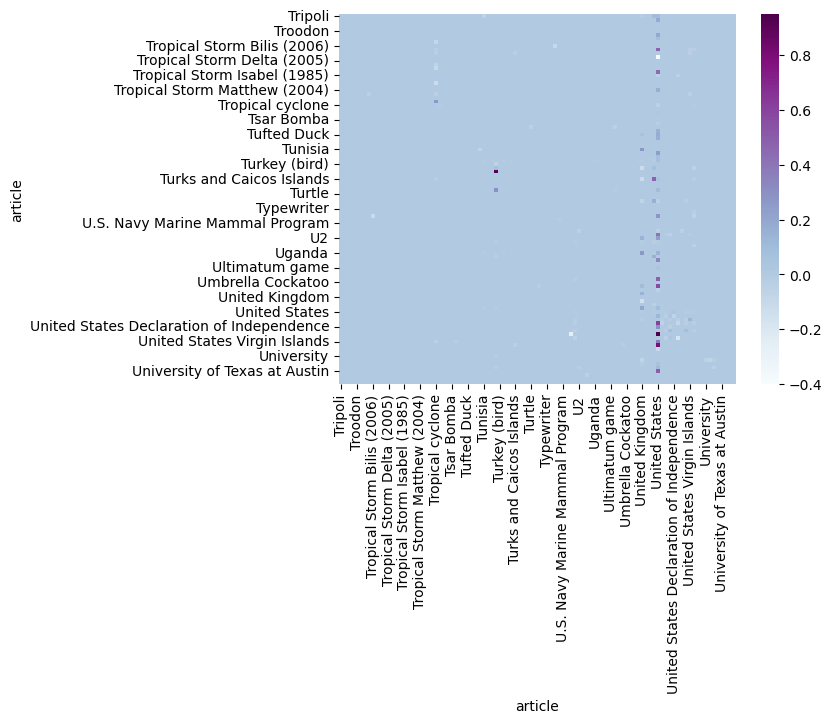

In [11]:
import seaborn as sn
import matplotlib.pyplot as plt
sn.heatmap(diff.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

In [13]:
KL = np.where((user_transitions > 0) & (markov_transitions > 0), user_transitions * np.log(user_transitions / markov_transitions), 0)
KL_df = pd.DataFrame(KL, columns=user_transitions.columns, index=user_transitions.index)
mean_KL = KL_df.sum(axis=0).sort_values(ascending=False)
mean_KL

c:\Users\yanni\.conda\envs\ada_project\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


article
United States           580.752776
Europe                  276.440782
England                 254.826100
United Kingdom          202.655357
World War II            126.872270
                           ...    
GNOME                    -0.265180
Abhidhamma Pitaka        -0.270310
The Supremes             -0.295799
Wikimedia Foundation     -0.329321
Action potential         -0.347136
Length: 4584, dtype: float64

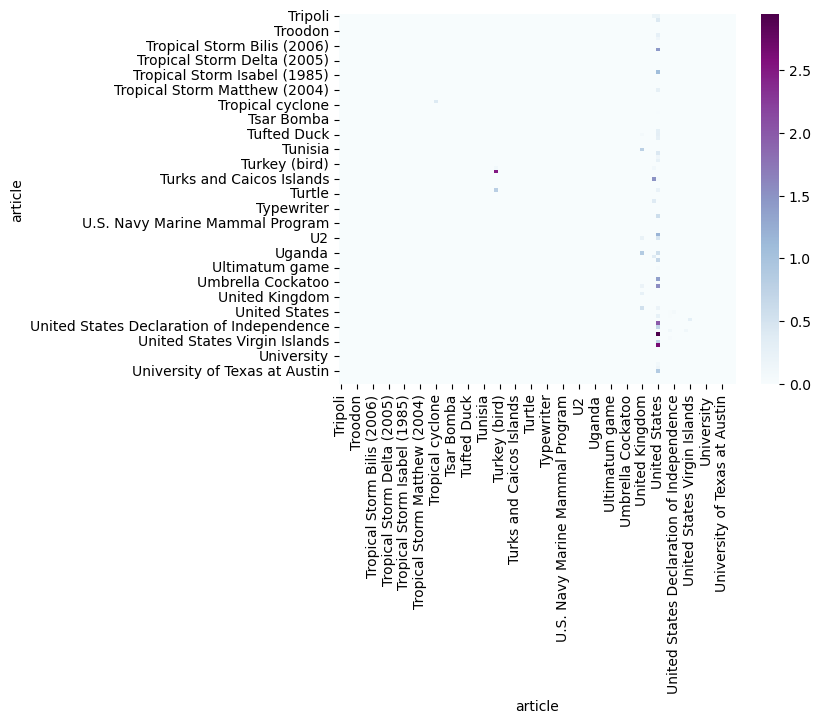

In [14]:
sn.heatmap(KL_df.iloc[4200:4300, 4200:4300], cmap='BuPu', cbar=True)
plt.show()

<div class="alert alert-block alert-success">

For the first transition, much more users go to United States or Europe than only following random transitions would.

<b>Notes:</b> 
- Values close to 0 means it is close to random behaviour. Values that are closer to -1 or 1 are the special behaviour, either clicking much more or much less on certain articles than random would predict.
- How could we remove the link position bias? Maybe check if certain links are on the top/bottom of the page and give more or less importance accordingly?
- Does adding backclicks as in the function above make sense?
</div>

## How does user's deviation from random path evolve during games ?


<div class="alert alert-block alert-success">

We can look at the difference between user games and random games at different steps of the game. This highlights the evolution of which articles palyers **voluntarily chose** to visit at different stages of the game. 
</div>

In [73]:
%%capture
mean_KL_step = get_step_divergences(df_article_names, parser, df_paths)

In [63]:
mean_KL_step.iloc[:5, :5]

1                   2                   3
                    mean       std      mean       std      mean
article                                                         
United States   0.117266  0.306368  0.056909  0.312469  0.023799
Europe          0.053836  0.211951  0.022400  0.195713  0.012401
England         0.051067  0.211649  0.025769  0.212493  0.012750
United Kingdom  0.039282  0.160167  0.021919  0.178657  0.007489
World War II    0.022942  0.117402  0.009356  0.102462  0.007576

In [64]:
mean_KL_step.columns

MultiIndex([( 1, 'mean'),
            ( 1,  'std'),
            ( 2, 'mean'),
            ( 2,  'std'),
            ( 3, 'mean'),
            ( 3,  'std'),
            ( 4, 'mean'),
            ( 4,  'std'),
            ( 5, 'mean'),
            ( 5,  'std'),
            ( 6, 'mean'),
            ( 6,  'std'),
            ( 7, 'mean'),
            ( 7,  'std'),
            ( 8, 'mean'),
            ( 8,  'std'),
            ( 9, 'mean'),
            ( 9,  'std'),
            (10, 'mean'),
            (10,  'std')],
           )

In [68]:
df_mean = mean_KL_step.xs('mean', level=1, axis=1)
df_std = mean_KL_step.xs('std', level=1, axis=1)
df_std.iloc[:5, :5]

,1,2,3,4,5
article,,,,,
United States,0.306368,0.312469,0.189296,0.148143,0.166196
Europe,0.211951,0.195713,0.168021,0.091898,0.035447
England,0.211649,0.212493,0.158779,0.148559,0.103701
United Kingdom,0.160167,0.178657,0.112654,0.107024,0.088527
World War II,0.117402,0.102462,0.114302,0.057090,0.080536


In [194]:
PALETTE_ARTICLE_DICT_COLORS = {}
for _, row in df_categories.iterrows():
    article = row['article']
    category = row['level_1']
    PALETTE_ARTICLE_DICT_COLORS[article] = config.PALETTE_CATEGORY_DICT.get(category, '#808080')

main_mean_div = mean_KL_step.iloc[:30]
plot_article_step_divergence(main_mean_div, PALETTE_ARTICLE_DICT_COLORS)

In [117]:
KL_n = np.where((user_transitions > 0) & (markov_transitions > 0),
                        user_transitions * np.log(user_transitions / markov_transitions), 0)
KL_n_df = pd.DataFrame(KL_n, columns=user_transitions.columns, index=user_transitions.index)

c:\Users\yanni\.conda\envs\ada_project\lib\site-packages\pandas\core\internals\blocks.py:329: RuntimeWarning:

divide by zero encountered in log



### What about the evolution of categories ?

In [186]:
%%capture

KL_cat_df = get_step_divergences(df_article_names, parser, df_paths, df_categories=df_categories)

In [187]:
KL_cat_df

1                   2                   3   \
                             mean       sem      mean       sem      mean   
level_1                                                                     
World Regions            0.000748  0.000013  0.000472  0.000015  0.000321   
Citizenship              0.000346  0.000013  0.000344  0.000023  0.000303   
Geography                0.000287  0.000011  0.000325  0.000020  0.000290   
Language and literature  0.000262  0.000013  0.000284  0.000024  0.000175   
Religion                 0.000238  0.000013  0.000301  0.000028  0.000269   
History                  0.000230  0.000007  0.000186  0.000011  0.000196   
Business Studies         0.000201  0.000016  0.000176  0.000023  0.000191   
Science                  0.000141  0.000004  0.000189  0.000008  0.000190   
Art                      0.000139  0.000019  0.000213  0.000047  0.000255   
Everyday life            0.000116  0.000006  0.000200  0.000015  0.000241   
Mathematics              0.000114  0.000016  0.000150  0.000028  0.000226   
IT                       0.000087  0.000012  0.000179  0.000027  0.000238   
Design and Technology    0.000066  0.000006  0.000103  0.000013  0.000133   
Music                    0.000054  0.000007  0.000134  0.000022  0.000172   
People                   0.000054  0.000003  0.000084  0.000007  0.000092   

                                         4                   5             \
                              sem      mean       sem      mean       sem   
level_1                                                                     
World Regions            0.000013  0.000284  0.000012  0.000274  0.000012   
Citizenship              0.000023  0.000320  0.000024  0.000321  0.000023   
Geography                0.000021  0.000277  0.000020  0.000257  0.000019   
Language and literature  0.000017  0.000223  0.000022  0.000169  0.000019   
Religion                 0.000026  0.000300  0.000030  0.000303  0.000029   
History                  0.000012  0.000198  0.000012  0.000205  0.000013   
Business Studies         0.000027  0.000209  0.000030  0.000229  0.000033   
Science                  0.000008  0.000206  0.000008  0.000217  0.000009   
Art                      0.000049  0.000243  0.000046  0.000291  0.000058   
Everyday life            0.000016  0.000252  0.000016  0.000284  0.000018   
Mathematics              0.000039  0.000212  0.000035  0.000272  0.000044   
IT                       0.000034  0.000263  0.000034  0.000210  0.000025   
Design and Technology    0.000014  0.000185  0.000017  0.000170  0.000017   
Music                    0.000026  0.000259  0.000034  0.000223  0.000030   
People                   0.000008  0.000130  0.000009  0.000129  0.000009   

                               6                   7                   8   \
                             mean       sem      mean       sem      mean   
level_1                                                                     
World Regions            0.000278  0.000012  0.000239  0.000011  0.000219   
Citizenship              0.000305  0.000023  0.000337  0.000027  0.000324   
Geography                0.000287  0.000021  0.000285  0.000022  0.000265   
Language and literature  0.000174  0.000020  0.000160  0.000019  0.000185   
Religion                 0.000242  0.000025  0.000237  0.000027  0.000271   
History                  0.000222  0.000014  0.000212  0.000014  0.000212   
Business Studies         0.000193  0.000029  0.000218  0.000031  0.000243   
Science                  0.000215  0.000009  0.000213  0.000009  0.000224   
Art                      0.000302  0.000055  0.000233  0.000047  0.000212   
Everyday life            0.000269  0.000018  0.000270  0.000018  0.000252   
Mathematics              0.000247  0.000044  0.000285  0.000054  0.000195   
IT                       0.000216  0.000029  0.000207  0.000028  0.000206   
Design and Technology    0.000171  0.000017  0.000164  0.000016  0.000157   
Music                    

In [192]:
plot_category_step_divergence(KL_cat_df, config.PALETTE_CATEGORY_DICT_COLORS)

<div class="alert alert-block alert-success">
The Countries and Geography categories have similar behaviors, having extreme values, both strongly positive values for the first transition (~200 and 70 respectively), and strongly negative values in later steps (between -500 and -1000 and between -350 and -550 respectively).

- The stronly positive values for the first transition shows strong evidence that the first click of players are voluntarily directed towards Countries and Geography articles.

- The strong negative values for following steps shows strong evidence that folowing the first clicks, players voluntarily direct their click towards other categories.  

Further study of the evolution of country and geography articles is needed to explore where those strong values come from.

Let's look at articles of the Countries category more specifically:
</div>

<div class="alert alert-block alert-success">
Interestingly, no strongly negative values appear in later steps. This indicates that the strong negative values in the category plot is likely due to the accumulation of many small negative deviation from the random path. 

Lets verify this assimption by grouping articles that stay close to the random path as 'Others' article, and plotting their mean, and the value of their sum. 
</div>

<div class="alert alert-block alert-success">
A great majority of countries articles are clicked close to randomly (the difference between player path and random path is close to 0), but they are so numerous that they cumulate to be very significant in the country category.

These articles being so influent in the category stats and being close to random, we could make the choice to ingore them by :
finding a way for them not to influence so much the category: by removing them? by expressing them under 'Other_mean'? how to justify this choice? 
</div>

### Categories normalised by transition probabilities

In [26]:
markov_transitions = get_transition_probabilities(df_article_names, parser, backclicks=False, normalise=False)

In [27]:
from src.utils.helpers import map_path_to_categories
article_to_category = dict(zip(df_categories['article'], df_categories['level_1']))
mapped_categories = map_path_to_categories(df_article_names, article_to_category)

In [28]:
transitions_per_category = pd.DataFrame({'category': mapped_categories, 'transition': markov_transitions.sum(axis=1)})
transitions_per_category=transitions_per_category.groupby('category', as_index=False).sum()
transitions_per_category

,category,transition
0,Art,1352.0
1,Business Studies,3217.0
2,Citizenship,9227.0
3,Countries,23090.0
4,Design and Technology,5533.0
5,Everyday life,10700.0
6,Geography,31885.0
7,History,19845.0
8,IT,1350.0
9,Language and literature,5518.0


In [29]:
from collections import Counter

category_counts = Counter(mapped_categories)
# Convert to a DataFrame if needed
category_counts_df = pd.DataFrame(category_counts.items(), columns=['category', 'count'])


In [30]:
result = pd.merge(category_counts_df , transitions_per_category, on='category')
result['ratio'] = result['count'] / result['transition']
result=result.sort_values(by='ratio')

C:\Users\yanni\AppData\Local\Temp\ipykernel_45684\4165116778.py:3: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




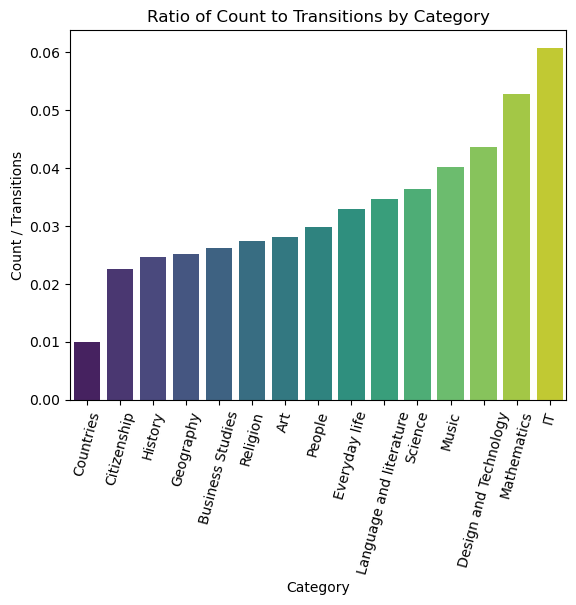

In [31]:
#TODO: adapt plot to colors and categories chosen

sn.barplot(data=result, x='category', y='ratio', palette='viridis')

# Customize the plot
plt.xlabel('Category')
plt.ylabel('Count / Transitions')
plt.title('Ratio of Count to Transitions by Category')
plt.xticks(rotation=75) 
plt.show()

In [32]:
import numpy as np

# Example matrices
P_user = np.array([[0.7, 0.3], [0.4, 0.6]])
P_random = np.array([[0.5, 0.5], [0.5, 0.5]])
print(f'user:\n{P_user}')
print(f'rand:\n{P_random}')

KL_matrix = np.where(P_user > 0, P_user * np.log(P_user / P_random), 0)

print("Element-wise KL Divergence Matrix:")
print(KL_matrix)


user:
[[0.7 0.3]
 [0.4 0.6]]
rand:
[[0.5 0.5]
 [0.5 0.5]]
Element-wise KL Divergence Matrix:
[[ 0.23553057 -0.15324769]
 [-0.08925742  0.10939293]]
